# Handwriting MNIST

In [48]:
import torch
import torchvision
from torchvision.datasets import MNIST
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
dataset = MNIST(root='data/', download=True)

100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



102.8%


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100.0%


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



112.7%

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [4]:
test_dataset = MNIST(root='data/', train=False)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


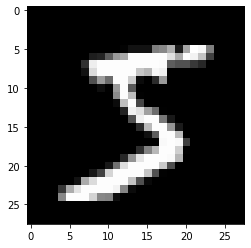

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:',label)

In [9]:
import torchvision.transforms as transforms

In [11]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [15]:
img_tensor, label = dataset[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

In [17]:
def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [18]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [22]:
batch_size = 64

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset,
                          batch_size,
                          sampler = train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset,
                        batch_size,
                        sampler = val_sampler)

In [24]:
input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [43]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1,784)
        # int_out = self.linear(xb)
        out = self.linear(xb)
        # out = nn.functional.softmax(int_out, dim = 1)
        return out

model = MnistModel()

In [28]:
model.linear.weight.shape, model.linear.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [29]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0280, -0.0060, -0.0339,  ..., -0.0143, -0.0321, -0.0166],
         [ 0.0252, -0.0145, -0.0077,  ..., -0.0106,  0.0153,  0.0202],
         [-0.0278,  0.0016, -0.0148,  ..., -0.0060, -0.0102, -0.0242],
         ...,
         [-0.0033, -0.0062, -0.0353,  ...,  0.0078, -0.0239, -0.0328],
         [-0.0259, -0.0030,  0.0075,  ..., -0.0122,  0.0289, -0.0171],
         [-0.0109,  0.0098, -0.0091,  ..., -0.0169,  0.0022, -0.0115]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0265, -0.0214, -0.0059,  0.0154,  0.0233, -0.0036, -0.0252, -0.0066,
         -0.0336,  0.0048], requires_grad=True)]

In [32]:
loss_fn = F.cross_entropy

In [33]:
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [35]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calculate the loss
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [41]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums))/total
        return avg_loss, avg_metric

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.sum(preds == labels).item()/len(preds)

In [49]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric = None):
    for epoch in range(epochs):
        for xb, yb in tqdm(train_dl):
            # Training
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

            # Evaluation
            result = evaluate(model, loss_fn, valid_dl, metric)
            val_loss, val_metric = result

        if metric is None:
            print(f'Epoch: [{epoch+1}/{epochs}], Loss: {val_loss:.2f}')
        else:
            print(f'Epoch: [{epoch+1}/{epochs}], Loss: {val_loss:.2f}, {metric.__name__.upper()}:{val_metric:.2f}')

In [50]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [51]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

100%|██████████| 750/750 [26:39<00:00,  2.13s/it]


Epoch: 1/5, Loss: 2.21, ACCURACY:0.27


  1%|          | 4/750 [00:10<31:20,  2.52s/it]


KeyboardInterrupt: 

Shape: torch.Size([1, 28, 28])
Label: 7


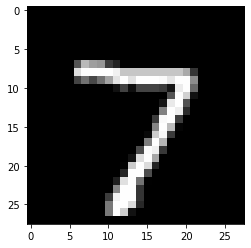

In [52]:
test_dataset = MNIST(root='data/', train = False, transform=transforms.ToTensor())
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print(f'Shape: {img.shape}')
print(f'Label: {label}')

In [54]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return preds[0].item()

Label: 7, Predicted: 7


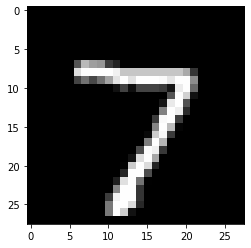

In [55]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print(f'Label: {label}, Predicted: {predict_image(img, model)}')

## Saving and Loading the Model

In [56]:
torch.save(model.state_dict(), './Saved_Model/mnist-logistic.pth')

In [58]:
model2 = MnistModel()
model2.load_state_dict(torch.load('Saved_Models\mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0326, -0.0278,  0.0072,  ...,  0.0119, -0.0313,  0.0011],
                      [ 0.0249, -0.0271, -0.0094,  ..., -0.0341,  0.0147,  0.0347],
                      [-0.0187, -0.0234, -0.0068,  ..., -0.0095,  0.0082,  0.0340],
                      ...,
                      [ 0.0228,  0.0311,  0.0197,  ..., -0.0213,  0.0194,  0.0341],
                      [ 0.0087, -0.0211, -0.0279,  ...,  0.0281,  0.0035,  0.0040],
                      [-0.0030,  0.0163,  0.0291,  ...,  0.0322, -0.0056, -0.0210]])),
             ('linear.bias',
              tensor([ 0.0092,  0.0130,  0.0173,  0.0134, -0.0166,  0.0146,  0.0094, -0.0127,
                      -0.0215,  0.0317]))])

## A Deeper Network

In [ ]:
class DeepMnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1,784)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out